In [1]:
#Imports
import numpy as np
from PIL import Image
#import mahotas as mt
import matplotlib.pylab as plt
import sys, os
from scipy.misc import imread
import json
from collections import defaultdict
from skimage.restoration import inpaint
from skimage import img_as_float, img_as_ubyte
import copy 
from skimage.transform import rotate, resize
from skimage import img_as_ubyte, img_as_float
from scipy import ndimage
import sys
sys.path.append('../tfs/image')
import poisson_blending
from mammo_tfs import *
%matplotlib inline

In [2]:
#Loading labels
ddsm_path = '../../../ddsm-data/benign_malignant'
labels_fl = 'mass_to_label.json'
labels_path = os.path.join(ddsm_path,labels_fl)

with open(labels_path) as data_file:    
    labels_data = json.load(data_file)

#labels_data is a filename -> label dict
mal_ind = 200
imlist = labels_data.keys()
mal_im  = imlist[mal_ind]
print mal_im
labels_data[imlist[mal_ind]]

P_00891_RIGHT_MLO.tif


1

In [4]:
IMAGE_DIM = 100
#Loading training set, defining path variables
train_path = os.path.join(ddsm_path,'train_set')
test_path = os.path.join(ddsm_path,'val_set')
val_path = os.path.join(ddsm_path,'test_set')
seg_path =  os.path.join(ddsm_path,'masks_cropped')

def load_batch(im_pth,seg_pth):
    im_dict = {}
    imlst = os.listdir(im_pth)
    for fl in imlst:
        tmp =  Image.open(os.path.join(im_pth,fl)) 
        try:
            seg =  Image.open(os.path.join(seg_pth,fl)) 
        except:
            continue
    #print labels_data[fl]
        tmp = np.squeeze(img_as_float(np.array(tmp.resize((IMAGE_DIM,IMAGE_DIM)))))
        seg = np.array(seg.resize((IMAGE_DIM,IMAGE_DIM)),dtype=np.uint8)
        imseg = np.stack((tmp,seg))
        im_dict[fl] = imseg
    print("Size of seg-tf set is %d out of %d possible" % (len(im_dict),len(imlst)))
    return im_dict
            

In [5]:
#Plotting image from train set
trn_data = load_batch(train_path,seg_path)
val_data = load_batch(val_path,seg_path)
test_data = load_batch(test_path,seg_path)

Size of seg-tf set is 1178 out of 1178 possible
Size of seg-tf set is 253 out of 253 possible
Size of seg-tf set is 253 out of 253 possible


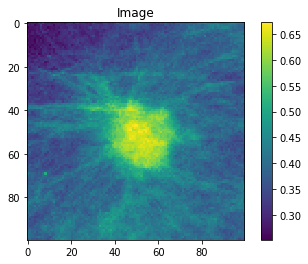

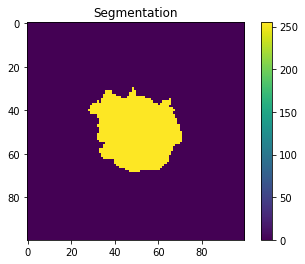

In [6]:
plt.figure()
plt.imshow(trn_data[imlist[mal_ind]][0,:,:],cmap='viridis')
plt.title('Image')
plt.colorbar()
plt.figure()
plt.imshow(trn_data[imlist[mal_ind]][1,:,:],cmap='viridis')
plt.colorbar()
plt.title('Segmentation')

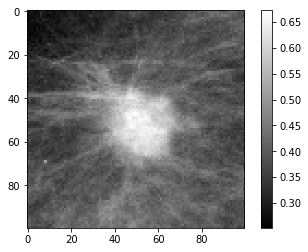

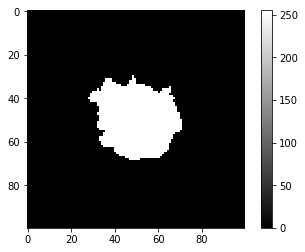

(100, 100) (100, 100) (100, 100, 2)


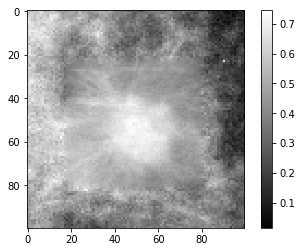

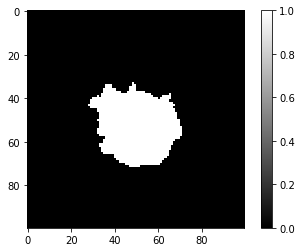

In [12]:
#NEW TESTING 10/5/2017

def TF_translate_structure_with_tissue2(imsg, translation=None, num_pixels=10, \
    target=None, dim=100):
    #convert format
    #imsg = np.uint8(img_as_float(imsg))
    imsg[:,:,0] = img_as_ubyte(imsg[:,:,0])
    #imsg = img_as_float(imsg)
    
    #translate/rotate/dilate segmentation
    args = np.where(imsg[:,:,1] != 0)
    bb, seg, _ = compute_bb(args, num_pixels, upper_bound=dim)
    h_lo, h_hi, w_lo, w_hi = bb
    h0, h1, w0, w1 = seg

    if not translation: 
        y_translate = np.random.randint(-h0, dim-h1)
        x_translate = np.random.randint(-w0, dim-w1)
    else:
        y_translate, x_translate = translation

        maxa0, mina0 = max(args[0]), min(args[0])
        maxa1, mina1 = max(args[1]), min(args[1])
        if y_translate + maxa0 >= dim: 
            y_translate = dim - maxa0 - 1
        if x_translate + maxa1 >= dim: 
            x_translate = dim - maxa1 - 1 
        if mina0 + y_translate < 0: 
            y_translate = -mina0
        if mina1 + x_translate < 0: 
            x_translate = -mina1
    
    new_seg_args = [args[0]+y_translate, args[1]+x_translate]
    mass_seg = imsg[h_lo:h_hi, w_lo:w_hi, 0]
    new_mask = np.zeros((dim, dim))
    new_mask[h_lo:h_hi,w_lo:w_hi] = 255
    
    
    #-39,15
    targt = target
  #  import pdb; pdb.set_trace()
    new_im = poisson_blending.blend(targt, imsg[:,:,0], \
            new_mask, offset=(y_translate, x_translate))    
    new_seg = np.zeros((dim, dim))
    new_seg[new_seg_args[0],new_seg_args[1]] = 255
    
    im = np.zeros((dim, dim, 2))
    im[:,:,0] = img_as_float(new_im.astype(np.uint8))
    im[:,:,1] = img_as_float(new_seg.astype(np.uint8))

    return img_as_float(im),new_mask


normal_file = '../../../ddsm-data/benign_malignant/normals/A_0224_1.LEFT_CC.tif'
tmp = Image.open(normal_file)
tgt = copy.deepcopy(np.array(tmp.resize((IMAGE_DIM,IMAGE_DIM))))
##Test TF Number 4
temp_img = np.transpose(copy.deepcopy(trn_data[imlist[mal_ind]]),(1,2,0))

plt.figure()
plt.imshow(temp_img[:,:,0], cmap='gray')
plt.colorbar()
#plt.clim(0,255)
plt.show()

plt.figure()
plt.imshow(temp_img[:,:,1], cmap='gray')
plt.colorbar()
#plt.clim(0,255)
plt.show()

im = TF_translate_structure_with_tissue(temp_img, num_pixels=10, translation=(3,0),\
    target=tgt,dim=100)

new_im, new_seg = im[:,:,0], im[:,:,1]
print new_im.shape, new_seg.shape, temp_img.shape
plt.figure()
plt.imshow(new_im, cmap='gray')
plt.colorbar()
plt.show()

plt.figure()
plt.imshow(new_seg, cmap='gray')
plt.colorbar()
plt.show()

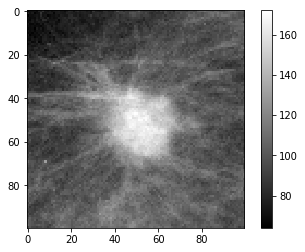

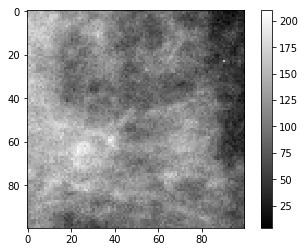

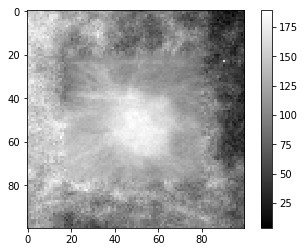

In [9]:
tmp2 = Image.open(normal_file)
tgt2 = copy.deepcopy(np.array(tmp2.resize((IMAGE_DIM,IMAGE_DIM))))
temp_img2 = copy.deepcopy(temp_img)
temp_img2[:,:,0] = img_as_ubyte(temp_img[:,:,0])

plt.figure()
plt.imshow(temp_img2[:,:,0], cmap='gray')
plt.colorbar()
plt.show()

plt.figure()
plt.imshow(tgt2, cmap='gray')
plt.colorbar()
plt.show()
out = poisson_blending.blend(tgt2, temp_img2[:,:,0], msk, offset=(0,0))    


plt.figure()
plt.imshow(out, cmap='gray')
plt.colorbar()
plt.show()






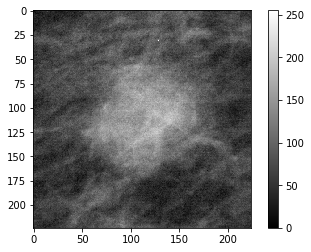

(224, 224, 2)
	 time for opening normal: 0.0123779773712
	 time for computing bb: 0.00159287452698
h_hi: 177
w_hi: 176
h_lo: 47
w_lo: 45
h1: 157
w1: 156
maxh: 92
lower bound: 45
upper bound: -45
y translate: -9
x translate: -35
	 time for blending: 1.43033385277
<type 'numpy.ndarray'>
(224, 224, 2)
<type 'numpy.ndarray'>
(224, 224, 2)
	 time for opening normal: 0.00104403495789
	 time for computing bb: 0.00156378746033
h_hi: 177
w_hi: 143
h_lo: 43
w_lo: 9
h1: 157
w1: 123
maxh: 94
lower bound: 51
upper bound: -47
y translate: -42
x translate: 90
	 time for blending: 1.26777100563
	 time for opening normal: 0.00358891487122
	 time for computing bb: 0.00178599357605
h_hi: 135
w_hi: 222
h_lo: 2
w_lo: 99
h1: 115
w1: 213
maxh: 90
lower bound: 88
upper bound: -1
y translate: 92
x translate: -109
	 time for blending: 1.03044915199
	 time for opening normal: 0.00158596038818
	 time for computing bb: 0.00168418884277
h_hi: 222
w_hi: 124
h_lo: 93
w_lo: 2
h1: 207
w1: 104
maxh: 88
lower bound: -5
u

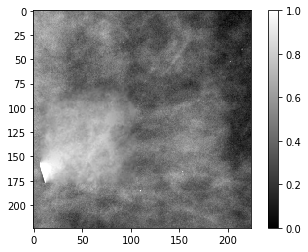

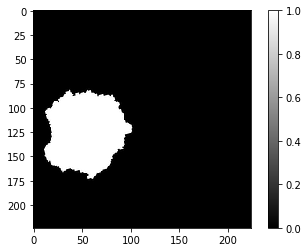

In [14]:
##Test TF number 2
temp_img = img_as_float(copy.deepcopy(trn_data[imlist[220]]))

plt.figure()
plt.imshow(np.uint8(img_as_ubyte(temp_img[0])), cmap='gray')
plt.colorbar()
plt.clim(0,255)
plt.show()

original = Image.fromarray(temp_img[0])
orig_mask = Image.fromarray(temp_img[1])
import time 
temp_img = np.transpose(temp_img, (1,2,0))
print temp_img.shape
# im = TF_translate_structure_with_tissue(temp_img, num_pixels=20, translation=(-68,-75))
im = TF_translate_structure_with_tissue(temp_img, num_pixels=20)
im = TF_rotate(im, angle=5)
im = TF_rotate(im, angle=5)
im = TF_enhance_contrast(im, p=0.9)
# im[:,:,0] = np.squeeze(im0)
#im = TF_enhance_contrast(im, p=1.15)
#im[:,:,0] = np.squeeze(im0)
im = TF_blur(im, sigma=0.1)
im = TF_blur(im, sigma=0.1)
# im = TF_zoom(im, scale=1.3)
# im = TF_zoom(im, scale=1.3)
# im = TF_zoom(im, scale=1.3)
im = TF_translate_structure_with_tissue(im, num_pixels=20)
im = TF_translate_structure_with_tissue(im, num_pixels=20)
im = TF_translate_structure_with_tissue(im, num_pixels=20)
im = TF_translate_structure_with_tissue(im, num_pixels=20)
im = TF_translate_structure_with_tissue(im, num_pixels=20)
im = TF_translate_structure_with_tissue(im, num_pixels=20, translation=(-10,-10))
im = TF_translate_structure_with_tissue(im, num_pixels=20, translation=(-10,-10))
im = TF_translate_structure_with_tissue(im, num_pixels=20)
im = TF_translate_structure_with_tissue(im, num_pixels=20)
im = TF_translate_structure_with_tissue(im, num_pixels=20)
im = TF_rotate_structure_with_tissue(im,num_pixels=1,p=15)


# start = time.time()
# im = TF_translate_structure_with_tissue(temp_img,num_pixels=20,translation=(39,15))
# end = time.time() 
# print "translate structure time:", end-start

# start = time.time()
# im2 = TF_rotate(np.expand_dims(temp_img[0],axis=2), angle=45)
# end = time.time()
# print "rotate time:", end-start

# start = time.time()
# im3 = TF_zoom(np.expand_dims(temp_img[0],axis=2), scale=1.5)
# end = time.time()
# print "zoom time:", end-start

# start = time.time()
# im4 = TF_rotate_structure_with_tissue(temp_img,num_pixels=20,p=50)
# end = time.time()
# print "rotate structure time:", end-start



new_im, new_seg = im[:,:,0], im[:,:,1]
plt.figure()
plt.imshow(new_im, cmap='gray')
plt.colorbar()
plt.clim(0,1)
plt.show()

plt.figure()
plt.imshow(new_seg, cmap='gray')
plt.colorbar()
plt.clim(0,1)
plt.show()

# new_im = new_im.astype(np.uint8)
# new = Image.fromarray(new_im)
# new.save('new_paper.tif')




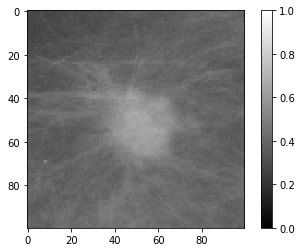

ValueError: Images of type float must be between -1 and 1.

In [61]:
##Test TF Number 3
temp_img = img_as_float(copy.deepcopy(trn_data[imlist[mal_ind]]))

plt.figure()
plt.imshow(temp_img[0], cmap='gray')
plt.colorbar()
plt.clim(0,1)
plt.show()

im = TF_rotate_structure_with_tissue(temp_img,num_pixels=20,p=50)
new_im, new_seg = im[0], im[1]
plt.figure()
plt.imshow(new_im, cmap='gray')
plt.colorbar()
plt.clim(0,1)
plt.show()

plt.figure()
plt.imshow(new_seg, cmap='gray')
plt.colorbar()
plt.clim(0,1)
plt.show()

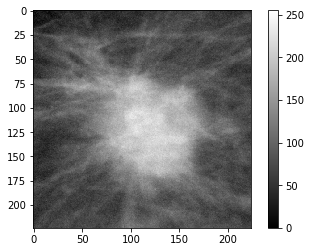

center: (111, 92)
hround: 58
wround: 63


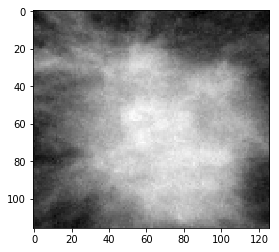

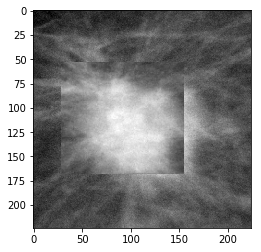

<type 'numpy.uint8'>
<type 'numpy.uint8'>


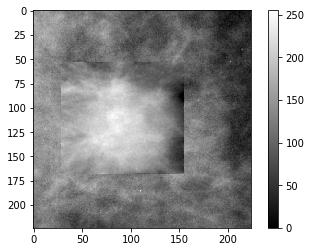

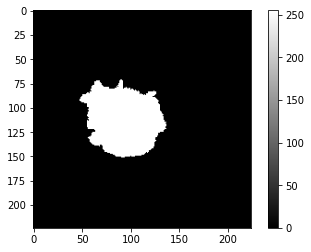

In [209]:
##Test TF Number 4
temp_img = copy.deepcopy(trn_data[imlist[mal_ind]])

plt.figure()
plt.imshow(temp_img[0], cmap='gray')
plt.colorbar()
plt.clim(0,255)
plt.show()

im = TF_dilate_structure_with_tissue(temp_img,num_pixels=20,p=-10)
new_im, new_seg = im[0], im[1]
plt.figure()
plt.imshow(new_im, cmap='gray')
plt.colorbar()
plt.clim(0,255)
plt.show()

plt.figure()
plt.imshow(new_seg, cmap='gray')
plt.colorbar()
plt.clim(0,255)
plt.show()

In [8]:
from tanda.transformer import SegmentTransformer 
from dataset import load_ddsm_data

from functools import partial 
from itertools import chain
import os
import sys
import sys
sys.path.append('../tfs/image')
import poisson_blending
from mammo_tfs import *
from image_tfs import *

dims     = [100, 100, 2]

#os.chdir('../../')

X_train, Y_train, X_valid, Y_valid, X_test, Y_test = load_ddsm_data(data_dir='../ddsm-data/benign_malignant', \
    label_json='../ddsm-data/benign_malignant/mass_to_label.json', validation_set=True)

X_batch = X_train[:10]
X_plot = X_batch 

tf_sets = []
tfs_15 = [
    [partial(TF_rotate, angle=p) for p in [2.5, -2.5, 5, -5]],
    [partial(TF_zoom, scale=p) for p in [0.98, 1.02]],
    [partial(TF_enhance_contrast, p=p) for p in [1.15, 1.05]],
    [partial(TF_translate_structure_with_tissue, translation=p, num_pixels=10, dim=100) \
        for p in [(-3,0), (3,0), (0,-3), (0,3)]],
    [partial(TF_rotate_structure_with_tissue, p=p, dim=100) \
        for p in [2.5, -2.5, 5, -5]]
]
tf_sets.append(list(chain.from_iterable(tfs_15)))
tfs = tf_sets[0]

transformer = SegmentTransformer(tfs, dims)
seq_len = 5
X_plot_r = transformer.random_transform(X_plot, seq_len, emit_incremental=False)
print X_plot_r.shape




loading in 1178 images...
loading in 253 images...
loading in 253 images...
(10, 10000)


(10, 10000)


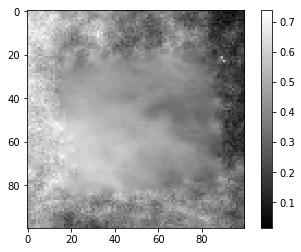

In [13]:
out = X_plot_r.reshape((10,100,100))
print X_plot_r.shape
plt.figure()
plt.imshow(out[0,:,:], cmap='gray')
plt.colorbar()
#plt.clim(0,255)
plt.show()

In [33]:
X_plot_r.reshape((10,100,100)).shape

(10, 100, 100)